### Load HIER code

In [1]:
import sys
sys.path.append('../hier')

### Install all package for visualization

In [ ]:
!pip install numba pandas matplotlib umap-learn[plot] holoviews
!pip install -q umap-learn
!pip install -U ipykernel

### Load libararies

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
import umap
import PIL
import umap.plot
from hyptorch import pmath
import numba
import matplotlib

In [4]:
@numba.njit()
def hyperboloid_grad(x, y):
    s = np.sqrt(1 + np.sum(x ** 2))
    t = np.sqrt(1 + np.sum(y ** 2))

    B = s * t
    for i in range(x.shape[0]):
        B -= x[i] * y[i]

    if B <= 1:
        B = 1.0 + 1e-8

    grad_coeff = 1.0 / (np.sqrt(B - 1) * np.sqrt(B + 1))

    grad = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        grad[i] = grad_coeff * (((x[i] * t) / s) - y[i])
        
    out = np.arccosh(B)
    
    return out, grad

@numba.njit()
def poincare(u, v):
    r"""Poincare distance.
    ..math::
        \delta (u, v) = 2 \frac{ \lVert  u - v \rVert ^2 }{ ( 1 - \lVert  u \rVert ^2 ) ( 1 - \lVert  v \rVert ^2 ) }
        D(x, y) = \operatorname{arcosh} (1+\delta (u,v))
    """
    sq_u_norm = np.sum(u * u)
    sq_v_norm = np.sum(v * v)
    sq_dist = np.sum(np.power(u - v, 2))
    return np.arccosh(1 + 2 * (sq_dist / ((1 - sq_u_norm) * (1 - sq_v_norm))))

### Load trained embeddings

In [5]:
emb_full = torch.load("cars_examples_train.pt")
num_emb = len(emb_full[0])
num_samples = min(12000, num_emb)

lca_full = torch.load("cars_examples_lca.pt")
num_lca = len(lca_full[0])
num_lcas = min(1000, num_lca)

ds_x, ds_y = emb_full[0], emb_full[1]
lca_x, lca_y = lca_full[0], lca_full[1]
sample_idxs = np.arange(0,num_emb)

ds_x_all = torch.cat([ds_x, lca_x])
ds_y_all = torch.cat([ds_y, lca_y])

mapper = umap.UMAP(output_metric="hyperboloid", random_state=42, n_neighbors=80, metric=poincare)


### Visualize hierachies of embeddings and LCAs by UMAP

/home/tjddus9597/.local/lib/python3.8/site-packages/umap/umap_.py:1772: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


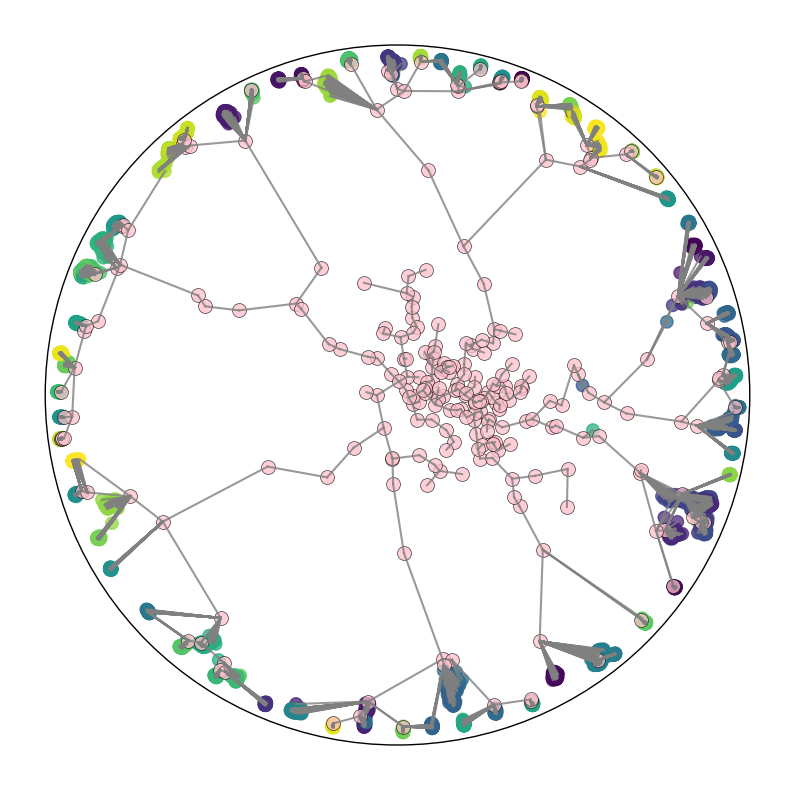

In [6]:
path2d = mapper.fit_transform(ds_x_all)
x, y = path2d[:, 0], path2d[:, 1]
z = (1 + x ** 2 + y ** 2) ** 0.5
disk_x_train = x / (1 + z)
disk_y_train = y / (1 + z)
coord_2d = path2d / (1+z)[:,None]
ds_y_train = ds_y

fig = plt.figure(figsize=(10, 10), clear=True)
ax = fig.add_subplot(111)
scatter = ax.scatter(disk_x_train[:num_samples], disk_y_train[:num_samples], c=ds_y_train[:num_samples], alpha=0.75, s=80)
scatter = ax.scatter(disk_x_train[num_samples:], disk_y_train[num_samples:], c='pink', alpha=0.75, s=100, linewidths=0.5, edgecolors='black')

dist = pmath.dist_matrix(torch.Tensor(coord_2d[:num_samples]), torch.Tensor(coord_2d[num_samples:]))
norm_mask = (torch.Tensor(coord_2d[:num_samples]).norm(2,1).unsqueeze(1) - torch.Tensor(coord_2d[num_samples:]).norm(2,1).unsqueeze(0)) < 0
dist = dist + norm_mask * 100
topk1_sample_lca = np.argmin(dist, -1)
x1 = disk_x_train[:num_samples]
y1 = disk_y_train[:num_samples]
x2 = disk_x_train[num_samples + topk1_sample_lca]
y2 = disk_y_train[num_samples + topk1_sample_lca]

for i in range(len(x1)):
    plt.plot([x1[i], x2[i]], [y1[i], y2[i]], color='gray', alpha = 0.8)
    
dist = pmath.dist_matrix(torch.Tensor(coord_2d[num_samples:]), torch.Tensor(coord_2d[num_samples:]))
dist = dist + torch.eye(len(dist)) * 100
norm_mask = (torch.Tensor(coord_2d[num_samples:]).norm(2,1).unsqueeze(1) - torch.Tensor(coord_2d[num_samples:]).norm(2,1).unsqueeze(0)) < 0
dist = dist + norm_mask * 100
topk1_lca_lca = np.argmin(dist, -1)
x1_lca = disk_x_train[num_samples:]
y1_lca = disk_y_train[num_samples:]
x2_lca = disk_x_train[num_samples + topk1_lca_lca]
y2_lca = disk_y_train[num_samples + topk1_lca_lca]
for i in range(len(x1_lca)):
    plt.plot([x1_lca[i], x2_lca[i]], [y1_lca[i], y2_lca[i]], color='gray', alpha = 0.8)
    
boundary = plt.Circle((0, 0), 1, fc="none", ec="k")
ax.add_patch(boundary)
ax.axis("off")
plt.show() 
# plt.savefig('Cars_hyperbolic_train_connect.png', dpi=300)